In [151]:
import pandas as pd
import numpy as np
from collections import Counter
import os
import glob
import math
from scipy import stats
import pandas_datareader as web
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm_old
import statsmodels.formula.api as sm
import scipy.optimize as sco
import scipy.interpolate as sci
from functools import reduce
import math 
import seaborn as sns

%matplotlib inline

In [152]:
working_wd = os.getcwd()
os.chdir(os.getcwd() + "/Return Data")

In [153]:
csv_return_data = glob.glob(os.path.join(os.getcwd(), "*.csv"))
csv_return_data.sort()

df_dict = {}

for i in csv_return_data:  # Create dictionary with all return dataframes
  file_name = i[54:-4]
  df_dict[file_name] = pd.read_csv(i)

for i in df_dict:   # Make date uniform for merge between df
  df_dict[i]["Date"] = df_dict[i].apply(lambda row: row.Date[0:7], axis=1)

In [154]:
df_merged = reduce(lambda left,right: pd.merge(left,right,on=['Date'], how='inner'), list(df_dict.values()))
df_merged.set_index('Date', inplace=True)
df_merged

,return_francisco,return_jorge,return_max,return_omar
Date,,,,
2008-01,0.108416,0.002078,-0.070062,0.016455
2008-02,0.052298,-0.016552,-0.083203,0.044417
2008-03,-0.059992,0.014374,-0.045938,0.024302
2008-04,-0.041588,-0.007020,-0.074392,-0.053905
2008-05,0.000846,0.026757,-0.065650,0.031691
...,...,...,...,...
2021-08,0.028585,0.044160,0.010954,-0.020277
2021-09,-0.044641,-0.003419,-0.012183,0.030546
2021-10,0.066874,0.027963,-0.025943,-0.025916


Change the order of columns to make it consistent with the written part, and change their names (gonna use Strategy i for now)

In [155]:
df_merged = df_merged[["return_max", "return_omar", "return_jorge", "return_francisco"]].rename(columns = {"return_max": "Strategy 1", "return_omar": "Strategy 2", "return_jorge": "Strategy 3", "return_francisco": "Strategy 4"})

Correlation Matrix

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'Strategy 1'),
  Text(0, 1.5, 'Strategy 2'),
  Text(0, 2.5, 'Strategy 3'),
  Text(0, 3.5, 'Strategy 4')])

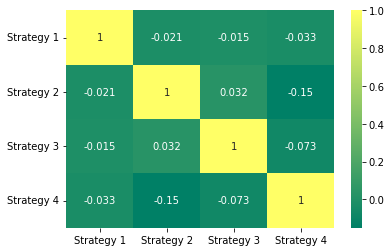

In [156]:
corr = df_merged[:"2018"].corr()
sns.heatmap(corr, cmap="summer", annot=True)
plt.yticks(rotation = "horizontal")

Optimization

In [157]:
df_training = df_merged[:"2018"]
df_testing = df_merged["2018":]

In [158]:
def calc_MDD(input):
  df = pd.Series(input, name="nw").to_frame()

  max_peaks_idx = df.nw.expanding(min_periods=1).apply(lambda x: x.argmax()).fillna(0).astype(int)
  df['max_peaks_idx'] = pd.Series(max_peaks_idx).to_frame()

  nw_peaks = pd.Series(df.nw.iloc[max_peaks_idx.values].values, index=df.nw.index)

  df['dd'] = ((df.nw-nw_peaks)/nw_peaks)
  df['mdd'] = df.groupby('max_peaks_idx').dd.apply(lambda x: x.expanding(min_periods=1).apply(lambda y: y.min())).fillna(0)

  return df

In [159]:
print("First Half")
print(" ")
for i in df_training.columns:
  print(i)
  first_half = df_training[i][0:int(round((len(df_training[i]) / 2)))]
  second_half = df_training[i][int(round((len(df_training[i]) / 2))):]
  
  total_return = round(((1 + first_half).cumprod()-1)[-1]*100,2)
  average_return = round((first_half.mean()*12)*100,2)
  standard_deviation = round((first_half.std())*math.sqrt(12)*100,2)
  kurtosis = round(first_half.kurt() - 3,2)
  skew = round(first_half.skew(),2)
  best_month = round(first_half.max()*100,2)
  worst_month = round(first_half.min()*100,2)
  positive_month = round(first_half[first_half > 0].shape[0] / len(first_half)*100,2)
  mdd = round(calc_MDD((1+first_half).cumprod())["mdd"].min()*100,2)

  print(f"Total Return = {total_return}%")
  print(f"Average Yearly Return = {average_return}%")
  print(f"Standard Deviation = {standard_deviation}%")
  print(f"Sharpe Ratio = {round(average_return / standard_deviation,2)}")
  print(f"Exess Kurtosis = {kurtosis}")
  print(f"Skewness = {skew}")
  print(f"Best Month = {best_month}%")
  print(f"Worst Month = {worst_month}%")
  print(f"Positive Month = {positive_month}%")
  print(f"Maximum Drawdown = {mdd}%")
  print(" ")

First Half
 
Strategy 1
Total Return = 585.57%
Average Yearly Return = 46.35%
Standard Deviation = 41.04%
Sharpe Ratio = 1.13
Exess Kurtosis = -1.04
Skewness = 1.57
Best Month = 41.19%
Worst Month = -8.75%
Positive Month = 50.0%
Maximum Drawdown = -43.81%
 
Strategy 2
Total Return = 10.96%
Average Yearly Return = 4.75%
Standard Deviation = 22.4%
Sharpe Ratio = 0.21
Exess Kurtosis = 5.31
Skewness = -1.46
Best Month = 19.42%
Worst Month = -28.08%
Positive Month = 61.67%
Maximum Drawdown = -51.97%
 
Strategy 3
Total Return = 6.91%
Average Yearly Return = 1.43%
Standard Deviation = 4.37%
Sharpe Ratio = 0.33
Exess Kurtosis = -1.59
Skewness = 0.62
Best Month = 3.86%
Worst Month = -2.63%
Positive Month = 41.67%
Maximum Drawdown = -4.0%
 
Strategy 4
Total Return = 29.45%
Average Yearly Return = 8.22%
Standard Deviation = 23.88%
Sharpe Ratio = 0.34
Exess Kurtosis = 2.82
Skewness = -1.58
Best Month = 12.57%
Worst Month = -30.41%
Positive Month = 63.33%
Maximum Drawdown = -57.23%
 


In [160]:
print("Second Half")
print(" ")
for i in df_training.columns:
  print(i)
  first_half = df_training[i][0:int(round((len(df_training[i]) / 2)))]
  second_half = df_training[i][int(round((len(df_training[i]) / 2))):]
  
  total_return = round(((1 + second_half).cumprod()-1)[-1]*100,2)
  average_return = round((second_half.mean()*12)*100,2)
  standard_deviation = round((second_half.std())*math.sqrt(12)*100,2)
  kurtosis = round(second_half.kurt() - 3,2)
  skew = round(second_half.skew(),2)
  best_month = round(second_half.max()*100,2)
  worst_month = round(second_half.min()*100,2)
  positive_month = round(second_half[second_half > 0].shape[0] / len(second_half)*100,2)
  mdd = round(calc_MDD((1+second_half).cumprod())["mdd"].min()*100,2)

  print(f"Total Return = {total_return}%")
  print(f"Average Yearly Return = {average_return}%")
  print(f"Standard Deviation = {standard_deviation}%")
  print(f"Sharpe Ratio = {round(average_return / standard_deviation,2)}")
  print(f"Exess Kurtosis = {kurtosis}")
  print(f"Skewness = {skew}")
  print(f"Best Month = {best_month}%")
  print(f"Worst Month = {worst_month}%")
  print(f"Positive Month = {positive_month}%")
  print(f"Maximum Drawdown = {mdd}%")
  print(" ")

Second Half
 
Strategy 1
Total Return = -87.29%
Average Yearly Return = -40.1%
Standard Deviation = 9.45%
Sharpe Ratio = -4.24
Exess Kurtosis = -3.49
Skewness = 0.38
Best Month = 3.58%
Worst Month = -8.04%
Positive Month = 13.33%
Maximum Drawdown = -87.31%
 
Strategy 2
Total Return = 5.53%
Average Yearly Return = 1.11%
Standard Deviation = 2.67%
Sharpe Ratio = 0.42
Exess Kurtosis = 2.69
Skewness = -0.49
Best Month = 2.66%
Worst Month = -3.04%
Positive Month = 55.0%
Maximum Drawdown = -4.31%
 
Strategy 3
Total Return = 42.73%
Average Yearly Return = 7.5%
Standard Deviation = 8.66%
Sharpe Ratio = 0.87
Exess Kurtosis = -1.0
Skewness = 0.37
Best Month = 9.37%
Worst Month = -5.78%
Positive Month = 60.0%
Maximum Drawdown = -8.41%
 
Strategy 4
Total Return = 45.68%
Average Yearly Return = 8.16%
Standard Deviation = 11.22%
Sharpe Ratio = 0.73
Exess Kurtosis = -2.15
Skewness = 0.14
Best Month = 10.93%
Worst Month = -7.65%
Positive Month = 63.33%
Maximum Drawdown = -18.51%
 


In [161]:
print("Full Sample Training")
print(" ")
for i in df_training.columns:
  print(i)
  first_half = df_training[i][0:int(round((len(df_training[i]) / 2)))]
  second_half = df_training[i][int(round((len(df_training[i]) / 2))):]
  
  total_return = round(((1 + df_training[i]).cumprod()-1)[-1]*100,2)
  average_return = round((df_training[i].mean()*12)*100,2)
  standard_deviation = round((df_training[i].std())*math.sqrt(12)*100,2)
  kurtosis = round(df_training[i].kurt() - 3,2)
  skew = round(df_training[i].skew(),2)
  best_month = round(df_training[i].max()*100,2)
  worst_month = round(df_training[i].min()*100,2)
  positive_month = round(df_training[df_training[i] > 0].shape[0] / len(df_training[i])*100,2)
  #mdd = round((((((1 + df_training[i]).cumprod()-1) - ((1 + df_training[i]).cumprod()-1).cummax()).min() /((1 + df_training[i]).cumprod()-1).max())*100),2)
  #mdd = round(((((1 + df_training[i]).cumprod() - (1 + df_training[i]).cumprod().cummax()).min() /(1 + df_training[i]).cumprod().max())*100),2)
  #mdd = round(((((1 + df_training[i]).cumprod() - (1 + df_training[i]).cumprod().cummax()).min())*100),2)
  mdd = round(calc_MDD((1+df_training[i]).cumprod())["mdd"].min()*100,2)
  
  print(f"Total Return = {total_return}%")
  print(f"Average Yearly Return = {average_return}%")
  print(f"Standard Deviation = {standard_deviation}%")
  print(f"Sharpe Ratio = {round(average_return / standard_deviation,2)}")
  print(f"Exess Kurtosis = {kurtosis}")
  print(f"Skewness = {skew}")
  print(f"Best Month = {best_month}%")
  print(f"Worst Month = {worst_month}%")
  print(f"Positive Month = {positive_month}%")
  print(f"Maximum Drawdown = {mdd}%")
  print(" ")

Full Sample Training
 
Strategy 1
Total Return = -12.86%
Average Yearly Return = 3.13%
Standard Deviation = 32.19%
Sharpe Ratio = 0.1
Exess Kurtosis = 3.67
Skewness = 2.49
Best Month = 41.19%
Worst Month = -8.75%
Positive Month = 31.67%
Maximum Drawdown = -93.27%
 
Strategy 2
Total Return = 17.09%
Average Yearly Return = 2.93%
Standard Deviation = 15.89%
Sharpe Ratio = 0.18
Exess Kurtosis = 14.98
Skewness = -1.9
Best Month = 19.42%
Worst Month = -28.08%
Positive Month = 58.33%
Maximum Drawdown = -51.97%
 
Strategy 3
Total Return = 52.6%
Average Yearly Return = 4.47%
Standard Deviation = 6.88%
Sharpe Ratio = 0.65
Exess Kurtosis = 0.59
Skewness = 0.66
Best Month = 9.37%
Worst Month = -5.78%
Positive Month = 50.83%
Maximum Drawdown = -8.41%
 
Strategy 4
Total Return = 88.59%
Average Yearly Return = 8.19%
Standard Deviation = 18.58%
Sharpe Ratio = 0.44
Exess Kurtosis = 5.72
Skewness = -1.61
Best Month = 12.57%
Worst Month = -30.41%
Positive Month = 63.33%
Maximum Drawdown = -57.23%
 


In [162]:
!pip install yfinance
import yfinance as yf
start = '2000-01-01'
end = '2022-12-01'
factors =['VBR','VUG','VTI','BND'] #acima de tudo, o VTI e BND *não* podem estar aqui presentes. Além disso, estes factors só têm data desde 2007
factor_data = yf.download(factors, interval = '1mo', start = start, end = end)['Adj Close']
factor_returns = factor_data.pct_change()

[*********************100%***********************]  4 of 4 completed


In [163]:
# Function for computing portfolio return, given weights
def portfolio_returns(weights, df_returns):
    return (np.sum(df_returns.mean() * weights)) * 12 #annualizing.

# Function for computing standard deviation of portfolio returns, given weights
def portfolio_sd(weights, df_returns):
    #return np.sqrt(np.transpose(weights) @ (df_returns.cov() * (12)**0.5) @ weights) # @ is matrix multiplication # why use square root here? in the orginal it just a normal number
    return np.sqrt(np.transpose(weights) @ (df_returns.cov() * (12)) @ weights) # @ is matrix multiplication # why use square root here? in the orginal it just a normal number
    #return np.transpose(weights) @ (df_returns.cov() * (12)**0.5) @ weights # @ is matrix multiplication # why use square root here? in the orginal it just a normal number

# instantiate empty list containers for returns and sd
port_returns = []
port_sd = []

# For loop to simulate 5000 random weight vectors (numpy array objects)
for p in range(5000):
    # Return random floats in the half-open interval [0.0, 1.0]
    weights = np.random.random(size = len(df_training.columns))
    
    # Normalize to unity (so that their sum equals 1)
    # The /= operator divides the array by the sum of the array and rebinds "weights" to the new object
    weights /= np.sum(weights)

    # Lists are mutable so growing will not be memory inefficient
    port_returns.append(portfolio_returns(weights, df_training))
    port_sd.append(portfolio_sd(weights, df_training))

# Convert list to numpy arrays
port_returns = np.array(object = port_returns)
port_sd = np.array(object = port_sd)

In [164]:
# Max expected return
round(max(port_returns), 4)

0.075

In [165]:
# Min expected return
round(min(port_returns), 4)

0.0312

In [166]:
# Max sd
round(max(port_sd), 4)

0.28

In [167]:
# Min sd
round(min(port_sd), 4)

0.0566

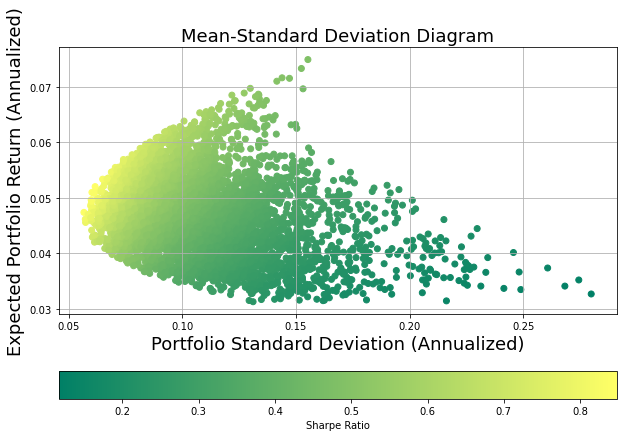

In [168]:
plt.figure(figsize=(10,7))
plt.scatter(port_sd, port_returns, c = port_returns/port_sd, cmap = 'summer')
plt.colorbar(label = 'Sharpe Ratio', orientation = 'horizontal')
plt.title('Mean-Standard Deviation Diagram', fontsize=18)
plt.xlabel('Portfolio Standard Deviation (Annualized)',fontsize=18)
plt.ylabel('Expected Portfolio Return (Annualized)',fontsize=18)
plt.grid()
plt.show()

In [169]:
# User defined Sharpe ratio function
# Negative sign to compute the negative value of Sharpe ratio, so we can use the minimize function
def sharpe_fun(weights, df_returns):
    return - (portfolio_returns(weights, df_returns) / portfolio_sd(weights, df_returns))

# We use an anonymous lambda function so that the weights sum up to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# This creates n (the number of strategies to combine) tuples of (0, 1), all of which exist within a container tuple
# We essentially create a sequence of (min, max) pairs
bounds = tuple((0, 1) for w in weights) # By using this (0,1), we are going lonly-only on our different strategies as a whole

# Repeat the list with the value (1 / n) n times, and convert list to array
equal_weights = np.array([1 / len(df_training.columns)] * len(df_training.columns))

Maximal Sharpe Ratio

In [170]:
# Again, the sharpe function 
# Minimization results
max_sharpe_port_results = sco.minimize(
  # Objective function
  fun = sharpe_fun, 
  # Initial guess, which is the equal weight array
  x0 = equal_weights,
  args = (df_training),
  method = 'SLSQP',
  bounds = bounds, 
  constraints = constraints
)

In [171]:
# Extract the weight composition array
max_sharpe_port_results["x"].round(4)

array([0.0276, 0.1051, 0.6727, 0.1946])

In [172]:
# Expected Annualized return
max_sharpe_port_return = portfolio_returns(max_sharpe_port_results["x"], df_training)

round(max_sharpe_port_return, 4)

0.0499

In [173]:
# Annualized Standard deviation
max_sharpe_port_sd = portfolio_sd(max_sharpe_port_results["x"], df_training)

round(max_sharpe_port_sd, 4)

0.0582

In [174]:
# Annualized Sharpe ratio
max_sharpe_port_sharpe = max_sharpe_port_return / max_sharpe_port_sd

round(max_sharpe_port_sharpe, 4)

0.8575

Minimum Variance Portfolio

In [175]:
# Minimize sd
min_sd_port_results = sco.minimize(
  # Objective function
  fun = portfolio_sd, 
  # Initial guess, which is the equal weight array
  x0 = equal_weights,
  args = (df_training),
  method = 'SLSQP',
  bounds = bounds, 
  constraints = constraints
)

In [176]:
# Extract the weight composition array
min_sd_port_results["x"].round(4)

array([0.037 , 0.1416, 0.6898, 0.1316])

In [177]:
# Expected Annualized return
min_sd_port_return = portfolio_returns(min_sd_port_results["x"], df_training)

round(min_sd_port_return, 4)

0.0469

In [178]:
# Annualized Standard deviation
min_sd_port_sd = portfolio_sd(min_sd_port_results["x"], df_training)

round(min_sd_port_sd, 4)

0.0564

In [179]:
# Annualized Sharpe ratio
min_sd_port_sharpe = min_sd_port_return / min_sd_port_sd

round(min_sd_port_sharpe, 4)

0.831

Efficient Frontier

In [180]:
# We use anonymous lambda functions
# The argument x will be the weights
constraints = ({'type': 'eq', 'fun': lambda x: portfolio_returns(x, df_training) - target}, {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# This creates n (the number of strategies to combine) tuples of (0, 1), all of which exist within a container tuple
# We essentially create a sequence of (min, max) pairs
bounds = tuple((0, 1) for w in weights) # By using this (0,1), we are going lonly-only on our different strategies as a whole

In [181]:
# Initialize an array of target returns
target = np.linspace(start = 0.03, stop = 0.08, num = 100) # <---------- '''These numbers need tuning, depending on the returns seen in the above graph. Until correct, the CML code bellow will not work'''

# instantiate empty container for the objective values to be minimized
obj_sd = []

# For loop to minimize objective function
for target in target: #do it 100 times
    min_result_object = sco.minimize(
    # Objective function
    fun = portfolio_sd, 
    # Initial guess, which is the equal weight array
    x0 = equal_weights,
    args = (df_training),
    method = 'SLSQP',
    bounds = bounds, 
    constraints = constraints
    )

    # Extract the objective value and append it to the output container
    obj_sd.append(min_result_object['fun'])

# End of for loop
# Convert list to array
obj_sd = np.array(obj_sd)

# Rebind target to a new array object
target = np.linspace(start = 0.03, stop = 0.08, num = 100) # <---------- '''These numbers need tuning, depending on the returns seen in the above graph. Until correct, the CML code below will not work'''

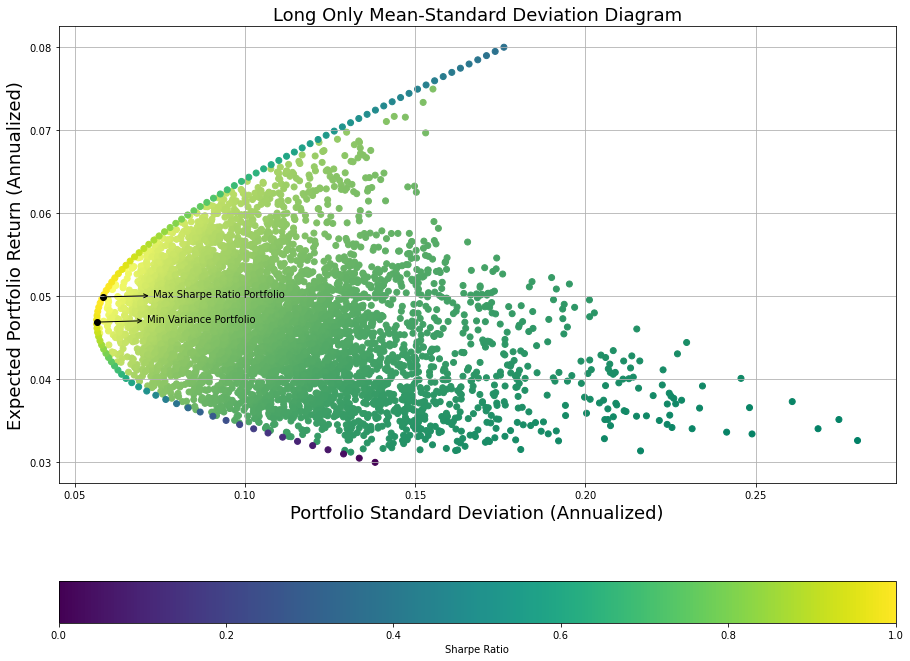

In [182]:
#Plotting the Mean-Standard Deviation Diagram
plt.figure(figsize=(15,12))
plt.scatter(port_sd, port_returns, c = port_returns/port_sd, cmap = 'summer')
plt.scatter(obj_sd, target, c = target/obj_sd, marker = 'o', alpha = 1) #Efficient Frontier
plt.scatter(max_sharpe_port_sd, max_sharpe_port_return, c = 'black', marker = 'o', alpha = 1) #Maximal Sharpe Ratio
plt.scatter(min_sd_port_sd, min_sd_port_return, c = 'black', marker = 'o', alpha = 1) #Minimum Variance Portfolio
plt.colorbar(label = 'Sharpe Ratio', orientation = 'horizontal')
plt.annotate('Max Sharpe Ratio Portfolio',(max_sharpe_port_sd, max_sharpe_port_return), xytext = (50, 0), textcoords = 'offset points', arrowprops = dict(arrowstyle='<-'))
plt.annotate('Min Variance Portfolio',(min_sd_port_sd, min_sd_port_return), xytext = (50, 0), textcoords = 'offset points', arrowprops=dict(arrowstyle='<-'))
plt.title('Long Only Mean-Standard Deviation Diagram', fontsize=18)
plt.xlabel('Portfolio Standard Deviation (Annualized)',fontsize=18)
plt.ylabel('Expected Portfolio Return (Annualized)',fontsize=18)
plt.grid()

plt.show()

Capital Market Line

In [183]:
# Efficient portfolio returns

# The function np.argmin() returns the indices of the minimum value(s)
# Take a slice starting from the minimum variance portfolio and exclude previous elements
efficient_sd = obj_sd[np.argmin(a = obj_sd):]

# Take a slice starting from the same index and exclude previous elements
efficient_returns = target[np.argmin(a = obj_sd):]

# Cubic spline interpolation
tck = sci.splrep(x = efficient_sd, y = efficient_returns)

# Define functional approximation of efficient frontier
def f(x, tck):
    return sci.splev(x = x, tck = tck, der = 0)

# Define first derivative of the efficient frontier
def df(x, tck):
    return sci.splev(x = x, tck = tck, der = 1)

# System of equations
r_f = 0.01 #'''Should we use the mean risk free rate over the whole investing period?'''
def sys_eq(p, tck, r_f): 
    # Equations
    eq1 = r_f - p[0]
    eq2 = p[1] - df(p[2], tck)
    eq3 = r_f + df(p[2], tck) * p[2] -  f(p[2], tck)
    # Output values
    return eq1, eq2, eq3

In [184]:
# Solve the linear systems
sol_set = sco.fsolve(
    # Equations to solve for
    func = sys_eq,
    # Initial guess for p
    # This can be determined by trial and error or from the plot above (may take more than one try). It should be around the tangency point  <---------- '''IMPORTANT'''
    x0 = [0.04, 1, 0.06],
    args = (tck, r_f)
)

In [185]:
# Sanity check, it should all be equal to 0
np.round(sys_eq(p = sol_set, tck = tck, r_f = r_f), 4)

array([0., 0., 0.])

Tangency Portfolio

In [186]:
# Constraints
# The target return is now f(x) where x is taken from the solution set above
constraints = ({'type': 'eq', 'fun': lambda x: portfolio_returns(x, df_training) - f(x = sol_set[2], tck = tck)}, {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# This creates n (the number of strategies to combine) tuples of (0, 1), all of which exist within a container tuple
# We essentially create a sequence of (min, max) pairs
bounds = tuple((0, 1) for w in weights) # By using this (0,1), we are going lonly-only on our different strategies as a whole

In [187]:
# Optimize
min_result_object_tangency = sco.minimize(
  # Objective function
  fun = portfolio_sd, 
  # Initial guess, which is the equal weight array
  x0 = equal_weights,
  args = (df_training),
  method = 'SLSQP',
  bounds = bounds, 
  constraints = constraints
)

In [188]:
# Extract the weight composition array
min_result_object_tangency["x"].round(4)

array([0.0254, 0.0968, 0.6687, 0.2091])

In [189]:
# Expected Annualized return
tangency_port_return = portfolio_returns(min_result_object_tangency["x"], df_training)

round(tangency_port_return, 4)

0.0506

In [190]:
# Annualized Standard deviation
tangency_port_sd = portfolio_sd(min_result_object_tangency["x"], df_training)

round(tangency_port_sd, 4)

0.0591

In [191]:
# Annualized Sharpe ratio
tangency_port_sharpe = tangency_port_return / tangency_port_sd

round(tangency_port_sharpe, 4)

0.8562

Capital Market Line

In [192]:
def cml(x, sol_set):
    return sol_set[0] + sol_set[1] * x #rf + slope * x

# Standard deviations
cml_sd = np.linspace(0.02, 0.105, 100)

# Expected returns
cml_exp_returns = cml(x = cml_sd, sol_set = sol_set)

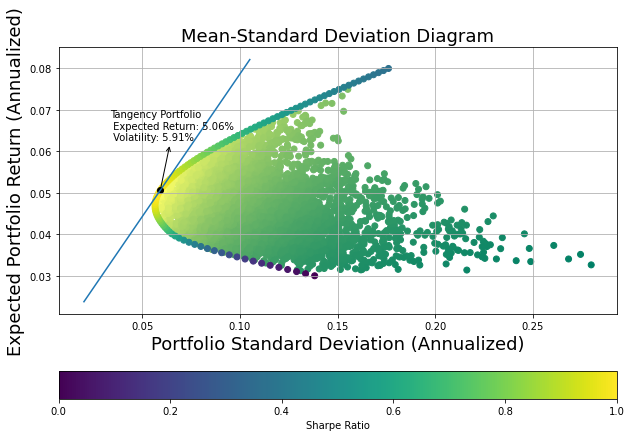

In [193]:
#Plotting the Mean-Standard Deviation Diagram
plt.figure(figsize=(10,7))
plt.scatter(port_sd, port_returns, c = port_returns/port_sd, cmap = 'summer')
plt.scatter(obj_sd, target, c = target/obj_sd, marker = 'o', alpha = 1) #Efficient Frontier
plt.scatter(tangency_port_sd, tangency_port_return, c = 'black', marker = 'o', alpha = 1) #Tangency Portfolio
plt.plot(cml_sd, cml_exp_returns) #Capital Market Line
plt.colorbar(label = 'Sharpe Ratio', orientation = 'horizontal')
plt.annotate('Tangency Portfolio \n Expected Return: {:.2f}% \n Volatility: {:.2f}%'.format(tangency_port_return*100, tangency_port_sd*100), (tangency_port_sd, tangency_port_return), xytext = (-50, 50), textcoords = 'offset points', arrowprops = dict(arrowstyle='<-'))
plt.title('Mean-Standard Deviation Diagram', fontsize=18)
plt.xlabel('Portfolio Standard Deviation (Annualized)',fontsize=18)
plt.ylabel('Expected Portfolio Return (Annualized)',fontsize=18)
plt.grid()

plt.show()

Comparing to Equal Weight

In [194]:
# Calculating series of returns for the EW portfolio
equal_weights = np.array([1 / len(df_training.columns)] * len(df_training.columns))

ew_port_returns = (equal_weights*df_training).sum(axis = 'columns') 
tangency_port_returns = (min_result_object_tangency["x"]*df_training).sum(axis = 'columns')

# Calculating annualized return, standard deviation, and sharpe ratio
ew_port_return = portfolio_returns(equal_weights, df_training)
ew_port_sd = portfolio_sd(equal_weights, df_training)

#ew_port_sharpe = portfolio_sharpe(equal_weights, df_training)
ew_port_sharpe = ew_port_return / ew_port_sd

# Calculating cumulative returns
ew_port_cum_returns = (ew_port_returns + 1).cumprod() - 1
tagency_port_cum_returns = (tangency_port_returns + 1).cumprod() - 1

In [195]:
def prepare_date_start(input_str):
  if int(input_str[5:]) == 1:
    year = str(int(input_str[0:4]) - 1)
    month = str(12)
    output = year + "-" + month
  else:
    year = str(int(input_str[0:4]))
    month = str(int(input_str[5:]) - 1)
    output = year + "-" + month
  return output

def prepare_date_end(input_str):
  if int(input_str[5:]) == 12:
    year = str(int(input_str[0:4]) + 1)
    month = str(1)
    output = year + "-" + month
  else:
    year = str(int(input_str[0:4]))
    month = str(int(input_str[5:]) + 1)
    output = year + "-" + month
  return output

def get_comp_returns(symbol):
  start = prepare_date_start(ew_port_returns.index[0]) + "-01"
  end = prepare_date_end(ew_port_returns.index[-1]) + "-1"
  factor_data = yf.download([symbol], interval = '1mo', start = start, end = end)['Adj Close']
  factor_returns = factor_data.pct_change()
  factor_returns = factor_returns.iloc[1:]
  return factor_returns

spy_returns = get_comp_returns("SPY")
agg_returns = get_comp_returns("AGG")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [196]:
sixty_forty_weights = np.array([0.6, 0.4])

sixty_forty_port = pd.concat([spy_returns,agg_returns],axis=1)

sixty_forty_port_returns = (sixty_forty_weights*sixty_forty_port).sum(axis = 'columns')

sixty_forty_return = portfolio_returns(sixty_forty_weights, sixty_forty_port)
sixty_forty_sd = portfolio_sd(sixty_forty_weights, sixty_forty_port)
sixty_forty_sharpe = sixty_forty_return / sixty_forty_sd

sixty_forty_cum_returns = (sixty_forty_port_returns + 1).cumprod() - 1

In [197]:
#!pip install pip install Riskfolio-Lib # uncomment if library isn't availaible
import riskfolio as rp

In [198]:
# https://medium.com/@orenji.eirl/vanilla-risk-parity-with-python-and-riskfolio-lib-3dfbfb752067

# Building the portfolio object
port = rp.Portfolio(returns=df_training)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
b = None # Risk contribution constraints vectorw_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

#display(w_rp.T)

risk_parity_weights = np.array(list(w_rp["weights"]))

risk_parity_port = df_training

risk_parity_port_returns = (risk_parity_weights*risk_parity_port).sum(axis = 'columns')

risk_parity_return = portfolio_returns(risk_parity_weights, risk_parity_port)
risk_parity_sd = portfolio_sd(risk_parity_weights, risk_parity_port)
risk_parity_sharpe = risk_parity_return / risk_parity_sd

risk_parity_cum_returns = (risk_parity_port_returns + 1).cumprod() - 1

In [199]:
ew_port_cum_returns.index = pd.to_datetime(ew_port_cum_returns.index)
tagency_port_cum_returns.index = pd.to_datetime(tagency_port_cum_returns.index)
risk_parity_cum_returns.index = pd.to_datetime(risk_parity_cum_returns.index)

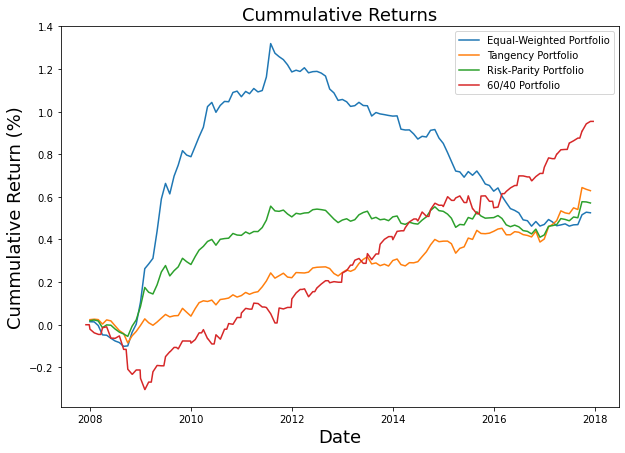

In [200]:
plt.figure(figsize=(10,7))
plt.plot(ew_port_cum_returns, label = 'Equal-Weighted Portfolio') #Equal Weight Portfolio
plt.plot(tagency_port_cum_returns, label = 'Tangency Portfolio') #Tangency Portfolio
plt.plot(risk_parity_cum_returns, label = 'Risk-Parity Portfolio') #Risk-Parity Portfolio
plt.plot(sixty_forty_cum_returns, label = '60/40 Portfolio') #60/40 Portfolio
plt.title('Cummulative Returns', fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Cummulative Return (%)',fontsize=18)
plt.legend()

plt.show()

In [201]:
def calc_MDD(input):
  df = pd.Series(input, name="nw").to_frame()

  max_peaks_idx = df.nw.expanding(min_periods=1).apply(lambda x: x.argmax()).fillna(0).astype(int)
  df['max_peaks_idx'] = pd.Series(max_peaks_idx).to_frame()

  nw_peaks = pd.Series(df.nw.iloc[max_peaks_idx.values].values, index=df.nw.index)

  df['dd'] = ((df.nw-nw_peaks)/nw_peaks)
  df['mdd'] = df.groupby('max_peaks_idx').dd.apply(lambda x: x.expanding(min_periods=1).apply(lambda y: y.min())).fillna(0)

  return df

In [202]:
from tabulate import tabulate

In [203]:
#create data
data = [['Maximal Sharpe Ratio', max_sharpe_port_return, max_sharpe_port_sd, max_sharpe_port_sharpe, 'x'],
        ['Minimum Variance', min_sd_port_return, min_sd_port_sd, min_sd_port_sharpe, 'x'],
        ['Tangency', tangency_port_return, tangency_port_sd, tangency_port_sharpe, 'x'],
        ['Equal-Weight', ew_port_return, ew_port_sd, ew_port_sharpe, 'x'],
        ["60 / 40", sixty_forty_return, sixty_forty_sd, sixty_forty_sharpe, "x"],
        ["Risk-Parity", risk_parity_return, risk_parity_sd, risk_parity_sharpe, "x"]]
  
#define header names
col_names = ['Ann. Excess Return', 'Ann. Stdev', 'Ann. Sharpe Ratio', 'Information Ratio'] #será que a IR se annualiza?
  
#display table
print(tabulate(data, headers=col_names, ))

                        Ann. Excess Return    Ann. Stdev    Ann. Sharpe Ratio  Information Ratio
--------------------  --------------------  ------------  -------------------  -------------------
Maximal Sharpe Ratio             0.0499245     0.0582223             0.857481  x
Minimum Variance                 0.0468919     0.0564251             0.831047  x
Tangency                         0.0506235     0.059124              0.856226  x
Equal-Weight                     0.0467779     0.0972037             0.481235  x
60 / 40                          0.0530331     0.0808725             0.655761  x
Risk-Parity                      0.0472774     0.0640254             0.738416  x


In [204]:
strat_dict = {"Tangency" : [tangency_port_return, tangency_port_sd, tangency_port_sharpe],
              "Equal Weight" : [ew_port_return, ew_port_sd, ew_port_sharpe],
              "60/40" : [sixty_forty_return, sixty_forty_sd, sixty_forty_sharpe],
              "Risk-Parity" : [risk_parity_return, risk_parity_sd, risk_parity_sharpe]}

comparison_dict_strat = {"Tangency" : tangency_port_returns,
                         "Equal Weight" : ew_port_returns,
                         "60/40" : sixty_forty_port_returns,
                         "Risk-Parity": risk_parity_port_returns,
                         "SPY": spy_returns,
                         "AGG": agg_returns}



for i in comparison_dict_strat:
  print(i)
  total_return = round(((1 + comparison_dict_strat[i]).cumprod()-1)[-1]*100,2)
  if i in strat_dict:
    average_return = round((strat_dict[i][0])*100,2)
    standard_deviation = round(strat_dict[i][1]*100,2)
  else:
    average_return = round((comparison_dict_strat[i].mean()*12)*100,2)
    standard_deviation = round((comparison_dict_strat[i].std())*math.sqrt(12)*100,2)
  kurtosis = round(comparison_dict_strat[i].kurt() - 3,2)
  skew = round(comparison_dict_strat[i].skew(),2)
  best_month = round(comparison_dict_strat[i].max()*100,2)
  worst_month = round(comparison_dict_strat[i].min()*100,2)
  positive_month = round(comparison_dict_strat[i][comparison_dict_strat[i] > 0].shape[0] / len(comparison_dict_strat[i])*100,2)
  #mdd = round(((((1 + comparison_dict_strat[i]).cumprod() - (1 + comparison_dict_strat[i]).cumprod().cummax()).min()/(1 + comparison_dict_strat[i]).cumprod().max())*100),2)
  mdd = round(calc_MDD((1+comparison_dict_strat[i]).cumprod())["mdd"].min()*100,2)
  print(f"Total Return = {total_return}%")
  print(f"Average Return = {average_return}%")
  print(f"Standard Deviation = {standard_deviation}%")
  print(f"Sharpe Ratio = {round(average_return / standard_deviation,2)}")
  print(f"Exess Kurtosis = {kurtosis}")
  print(f"Skewness = {skew}")
  print(f"Best Month = {best_month}%")
  print(f"Worst Month = {worst_month}%")
  print(f"Positive Month = {positive_month}%")
  print(f"Maximum Drawdown = {mdd}%")
  print(" ")

Tangency
Total Return = 62.91%
Average Return = 5.06%
Standard Deviation = 5.91%
Sharpe Ratio = 0.86
Exess Kurtosis = -1.96
Skewness = 0.2
Best Month = 6.68%
Worst Month = -4.57%
Positive Month = 60.0%
Maximum Drawdown = -10.84%
 
Equal Weight
Total Return = 52.53%
Average Return = 4.68%
Standard Deviation = 9.72%
Sharpe Ratio = 0.48
Exess Kurtosis = 4.15
Skewness = 2.31
Best Month = 14.18%
Worst Month = -4.42%
Positive Month = 44.17%
Maximum Drawdown = -36.94%
 
60/40
Total Return = 95.42%
Average Return = 5.3%
Standard Deviation = 8.09%
Sharpe Ratio = 0.66
Exess Kurtosis = 2.4
Skewness = -0.69
Best Month = 6.95%
Worst Month = -10.54%
Positive Month = 36.41%
Maximum Drawdown = -30.39%
 
Risk-Parity
Total Return = 57.14%
Average Return = 4.73%
Standard Deviation = 6.4%
Sharpe Ratio = 0.74
Exess Kurtosis = -0.04
Skewness = 1.18
Best Month = 8.23%
Worst Month = -3.8%
Positive Month = 52.5%
Maximum Drawdown = -9.38%
 
SPY
Total Return = 125.0%
Average Return = 6.93%
Standard Deviation = 1

In [205]:
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following
# out of sample following

**Out of sample testing**

In [206]:
print("Full Sample Testing")
print(" ")
for i in df_testing.columns:
  print(i)
  first_half = df_testing[i][0:int(round((len(df_testing[i]) / 2)))]
  second_half = df_testing[i][int(round((len(df_testing[i]) / 2))):]
  
  total_return = round(((1 + df_testing[i]).cumprod()-1)[-1]*100,2)
  average_return = round((df_testing[i].mean()*12)*100,2)
  standard_deviation = round((df_testing[i].std())*math.sqrt(12)*100,2)
  kurtosis = round(df_testing[i].kurt() - 3,2)
  skew = round(df_testing[i].skew(),2)
  best_month = round(df_testing[i].max()*100,2)
  worst_month = round(df_testing[i].min()*100,2)
  positive_month = round(df_testing[df_testing[i] > 0].shape[0] / len(df_testing[i])*100,2)
  #mdd = round(((((1 + df_testing[i]).cumprod() - (1 + df_testing[i]).cumprod().cummax()).min()/(1 + df_testing[i]).cumprod().max())*100),2)
  mdd = round(calc_MDD((1+df_testing[i]).cumprod())["mdd"].min()*100,2)
  print(f"Total Return = {total_return}%")
  print(f"Average Yearly Return = {average_return}%")
  print(f"Standard Deviation = {standard_deviation}%")
  print(f"Sharpe Ratio = {round(average_return / standard_deviation,2)}")
  print(f"Exess Kurtosis = {kurtosis}")
  print(f"Skewness = {skew}")
  print(f"Best Month = {best_month}%")
  print(f"Worst Month = {worst_month}%")
  print(f"Positive Month = {positive_month}%")
  print(f"Maximum Drawdown = {mdd}%")
  print(" ")

Full Sample Testing
 
Strategy 1
Total Return = -7.58%
Average Yearly Return = -1.0%
Standard Deviation = 15.62%
Sharpe Ratio = -0.06
Exess Kurtosis = -1.39
Skewness = -0.11
Best Month = 12.7%
Worst Month = -11.97%
Positive Month = 53.49%
Maximum Drawdown = -40.09%
 
Strategy 2
Total Return = -30.16%
Average Yearly Return = -9.57%
Standard Deviation = 9.03%
Sharpe Ratio = -1.06
Exess Kurtosis = -2.16
Skewness = -0.68
Best Month = 4.41%
Worst Month = -7.97%
Positive Month = 37.21%
Maximum Drawdown = -35.97%
 
Strategy 3
Total Return = 31.92%
Average Yearly Return = 8.25%
Standard Deviation = 10.08%
Sharpe Ratio = 0.82
Exess Kurtosis = 0.69
Skewness = -0.21
Best Month = 9.42%
Worst Month = -9.32%
Positive Month = 53.49%
Maximum Drawdown = -15.7%
 
Strategy 4
Total Return = 81.41%
Average Yearly Return = 17.85%
Standard Deviation = 15.2%
Sharpe Ratio = 1.17
Exess Kurtosis = -3.07
Skewness = -0.13
Best Month = 11.8%
Worst Month = -8.0%
Positive Month = 65.12%
Maximum Drawdown = -8.2%
 


In [207]:
# Calculating series of returns for the EW portfolio

tangency_port_return = portfolio_returns(min_result_object_tangency["x"], df_testing)
tangency_port_sd = portfolio_sd(min_result_object_tangency["x"], df_testing)
tangency_port_sharpe = tangency_port_return / tangency_port_sd
tangency_port_returns = (min_result_object_tangency["x"]*df_testing).sum(axis = 'columns')

equal_weights = np.array([1 / len(df_testing.columns)] * len(df_testing.columns))

ew_port_returns = (equal_weights*df_testing).sum(axis = 'columns') 


# Calculating annualized return, standard deviation, and sharpe ratio
ew_port_return = portfolio_returns(equal_weights, df_testing)
ew_port_sd = portfolio_sd(equal_weights, df_testing)

#ew_port_sharpe = portfolio_sharpe(equal_weights, df_testing)
ew_port_sharpe = ew_port_return / ew_port_sd

# Calculating cumulative returns
ew_port_cum_returns = (ew_port_returns + 1).cumprod() - 1
tagency_port_cum_returns = (tangency_port_returns + 1).cumprod() - 1

In [208]:
def prepare_date_start(input_str):
  if int(input_str[5:]) == 1:
    year = str(int(input_str[0:4]) - 1)
    month = str(12)
    output = year + "-" + month
  else:
    year = str(int(input_str[0:4]))
    month = str(int(input_str[5:]) - 1)
    output = year + "-" + month
  return output

def prepare_date_end(input_str):
  if int(input_str[5:]) == 12:
    year = str(int(input_str[0:4]) + 1)
    month = str(1)
    output = year + "-" + month
  else:
    year = str(int(input_str[0:4]))
    month = str(int(input_str[5:]) + 1)
    output = year + "-" + month
  return output

def get_comp_returns(symbol):
  start = prepare_date_start(ew_port_returns.index[0]) + "-01"
  end = prepare_date_end(ew_port_returns.index[-1]) + "-1"
  factor_data = yf.download([symbol], interval = '1mo', start = start, end = end)['Adj Close']
  factor_returns = factor_data.pct_change()
  factor_returns = factor_returns.iloc[1:]
  return factor_returns

spy_returns = get_comp_returns("SPY")
agg_returns = get_comp_returns("AGG")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [209]:
sixty_forty_weights = np.array([0.6, 0.4])

sixty_forty_port = pd.concat([spy_returns,agg_returns],axis=1)

sixty_forty_port_returns = (sixty_forty_weights*sixty_forty_port).sum(axis = 'columns')

sixty_forty_return = portfolio_returns(sixty_forty_weights, sixty_forty_port)
sixty_forty_sd = portfolio_sd(sixty_forty_weights, sixty_forty_port)
sixty_forty_sharpe = sixty_forty_return / sixty_forty_sd

sixty_forty_cum_returns = (sixty_forty_port_returns + 1).cumprod() - 1

In [210]:
# https://medium.com/@orenji.eirl/vanilla-risk-parity-with-python-and-riskfolio-lib-3dfbfb752067

# Building the portfolio object
port = rp.Portfolio(returns=df_testing)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
b = None # Risk contribution constraints vectorw_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

#display(w_rp.T)

risk_parity_weights = np.array(list(w_rp["weights"]))

risk_parity_port = df_testing

risk_parity_port_returns = (risk_parity_weights*risk_parity_port).sum(axis = 'columns')

risk_parity_return = portfolio_returns(risk_parity_weights, risk_parity_port)
risk_parity_sd = portfolio_sd(risk_parity_weights, risk_parity_port)
risk_parity_sharpe = risk_parity_return / risk_parity_sd

risk_parity_cum_returns = (risk_parity_port_returns + 1).cumprod() - 1

In [211]:
ew_port_cum_returns.index = pd.to_datetime(ew_port_cum_returns.index)
tagency_port_cum_returns.index = pd.to_datetime(tagency_port_cum_returns.index)
risk_parity_cum_returns.index = pd.to_datetime(risk_parity_cum_returns.index)

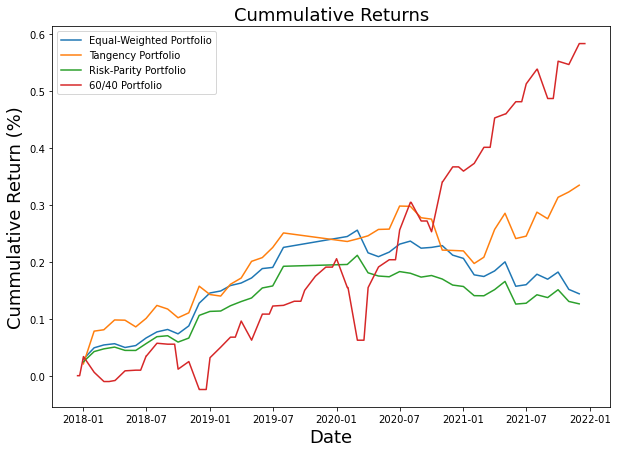

In [212]:
plt.figure(figsize=(10,7))
plt.plot(ew_port_cum_returns, label = 'Equal-Weighted Portfolio') #Equal Weight Portfolio
plt.plot(tagency_port_cum_returns, label = 'Tangency Portfolio') #Tangency Portfolio
plt.plot(risk_parity_cum_returns, label = 'Risk-Parity Portfolio') #Risk-Parity Portfolio
plt.plot(sixty_forty_cum_returns, label = '60/40 Portfolio') #60/40 Portfolio
plt.title('Cummulative Returns', fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Cummulative Return (%)',fontsize=18)
plt.legend()

plt.show()

In [213]:
strat_dict = {"Tangency" : [tangency_port_return, tangency_port_sd, tangency_port_sharpe],
              "Equal Weight" : [ew_port_return, ew_port_sd, ew_port_sharpe],
              "60/40" : [sixty_forty_return, sixty_forty_sd, sixty_forty_sharpe],
              "Risk-Parity" : [risk_parity_return, risk_parity_sd, risk_parity_sharpe]}

comparison_dict_strat = {"Tangency" : tangency_port_returns,
                         "Equal Weight" : ew_port_returns,
                         "60/40" : sixty_forty_port_returns,
                         "Risk-Parity": risk_parity_port_returns,
                         "SPY": spy_returns,
                         "AGG": agg_returns}



for i in comparison_dict_strat:
  print(i)
  total_return = round(((1 + comparison_dict_strat[i]).cumprod()-1)[-1]*100,2)
  if i in strat_dict:
    average_return = round((strat_dict[i][0])*100,2)
    standard_deviation = round(strat_dict[i][1]*100,2)
  else:
    average_return = round((comparison_dict_strat[i].mean()*12)*100,2)
    standard_deviation = round((comparison_dict_strat[i].std())*math.sqrt(12)*100,2)
  kurtosis = round(comparison_dict_strat[i].kurt() - 3,2)
  skew = round(comparison_dict_strat[i].skew(),2)
  best_month = round(comparison_dict_strat[i].max()*100,2)
  worst_month = round(comparison_dict_strat[i].min()*100,2)
  positive_month = round(comparison_dict_strat[i][comparison_dict_strat[i] > 0].shape[0] / len(comparison_dict_strat[i])*100,2)
  #mdd = round(((((1 + comparison_dict_strat[i]).cumprod() - (1 + comparison_dict_strat[i]).cumprod().cummax()).min()/(1 + comparison_dict_strat[i]).cumprod().max())*100),2)
  mdd = round(calc_MDD((1+comparison_dict_strat[i]).cumprod())["mdd"].min()*100,2)
  print(f"Total Return = {total_return}%")
  print(f"Average Return = {average_return}%")
  print(f"Standard Deviation = {standard_deviation}%")
  print(f"Sharpe Ratio = {round(average_return / standard_deviation,2)}")
  print(f"Exess Kurtosis = {kurtosis}")
  print(f"Skewness = {skew}")
  print(f"Best Month = {best_month}%")
  print(f"Worst Month = {worst_month}%")
  print(f"Positive Month = {positive_month}%")
  print(f"Maximum Drawdown = {mdd}%")
  print(" ")

Tangency
Total Return = 33.45%
Average Return = 8.3%
Standard Deviation = 6.72%
Sharpe Ratio = 1.24
Exess Kurtosis = -2.25
Skewness = 0.04
Best Month = 5.63%
Worst Month = -4.26%
Positive Month = 62.79%
Maximum Drawdown = -7.77%
 
Equal Weight
Total Return = 14.38%
Average Return = 3.88%
Standard Deviation = 5.15%
Sharpe Ratio = 0.75
Exess Kurtosis = -1.96
Skewness = -0.53
Best Month = 3.67%
Worst Month = -3.57%
Positive Month = 69.77%
Maximum Drawdown = -8.9%
 
60/40
Total Return = 58.32%
Average Return = 8.92%
Standard Deviation = 9.24%
Sharpe Ratio = 0.97
Exess Kurtosis = 0.32
Skewness = 0.04
Best Month = 8.7%
Worst Month = -8.01%
Positive Month = 42.17%
Maximum Drawdown = -11.87%
 
Risk-Parity
Total Return = 12.61%
Average Return = 3.42%
Standard Deviation = 4.51%
Sharpe Ratio = 0.76
Exess Kurtosis = -1.3
Skewness = -0.14
Best Month = 3.74%
Worst Month = -3.42%
Positive Month = 60.47%
Maximum Drawdown = -7.07%
 
SPY
Total Return = 91.06%
Average Return = 13.15%
Standard Deviation =

In [214]:
# Regression Analysis - Sample Period

In [215]:
tangency_port_return = portfolio_returns(min_result_object_tangency["x"], df_training)
tangency_port_sd = portfolio_sd(min_result_object_tangency["x"], df_training)
tangency_port_sharpe = tangency_port_return / tangency_port_sd
tangency_port_returns = (min_result_object_tangency["x"]*df_training).sum(axis = 'columns').rename('Tangency Portfolio').to_frame()


In [216]:
os.chdir(working_wd)
os.chdir(os.getcwd() + "/FF3 Data")

ff3_df = pd.read_csv("FF3 Data.csv")
ff3_df['Date'] = ff3_df['Date'].astype(str)
ff3_df["Date"] = ff3_df.apply(lambda row: str(row.Date[0:4]) + "-" + str(row.Date[4:6]), axis=1)
ff3_df.set_index('Date', inplace=True)
for i in ff3_df.columns:
    ff3_df[i] = ff3_df[i].div(100)

regression_df = pd.merge(tangency_port_returns, ff3_df, left_index=True, right_index=True)

In [217]:
# CAPM Model Full Sample
print("Full Sample")

Y_capm = regression_df["Tangency Portfolio"]
X_capm = regression_df["Mkt-RF"]
X_sm_capm = sm_old.add_constant(X_capm)
capm_model = sm_old.OLS(Y_capm,X_sm_capm)  
capm_results = capm_model.fit()
print(capm_results.summary())
# print(" ")

# FF3 Model Full Sample
print("Full Sample")

factors = ['Mkt-RF', 'SMB', 'HML']

Y_ff3 = regression_df["Tangency Portfolio"]
X_ff3 = regression_df[factors]
X_sm_ff3 = sm_old.add_constant(X_ff3)
ff3_model = sm_old.OLS(Y_ff3,X_sm_ff3)  
ff3_results = ff3_model.fit()
print(ff3_results.summary())
print(" ")

Full Sample
                            OLS Regression Results                            
Dep. Variable:     Tangency Portfolio   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.1699
Date:                Thu, 15 Dec 2022   Prob (F-statistic):              0.681
Time:                        21:40:49   Log-Likelihood:                 318.78
No. Observations:                 120   AIC:                            -633.6
Df Residuals:                     118   BIC:                            -628.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.002      2.

In [218]:
# CAPM Model First Half Sample
print("First Half Sample")

reg_df = np.array_split(regression_df, 2)[0]
Y_capm = reg_df["Tangency Portfolio"]
X_capm = reg_df["Mkt-RF"]
X_sm_capm = sm_old.add_constant(X_capm)
capm_model = sm_old.OLS(Y_capm,X_sm_capm)  
capm_results = capm_model.fit()
print(capm_results.summary())
# print(" ")

# FF3 Model First Half Sample
print("First Half Sample")

factors = ['Mkt-RF', 'SMB', 'HML']

Y_ff3 = reg_df["Tangency Portfolio"]
X_ff3 = reg_df[factors]
X_sm_ff3 = sm_old.add_constant(X_ff3)
ff3_model = sm_old.OLS(Y_ff3,X_sm_ff3)  
ff3_results = ff3_model.fit()
print(ff3_results.summary())
print(" ")

First Half Sample
                            OLS Regression Results                            
Dep. Variable:     Tangency Portfolio   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                   0.03559
Date:                Thu, 15 Dec 2022   Prob (F-statistic):              0.851
Time:                        21:40:49   Log-Likelihood:                 158.39
No. Observations:                  60   AIC:                            -312.8
Df Residuals:                      58   BIC:                            -308.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.002  

In [219]:
# CAPM Model Second Half Sample
print(" Second Half Sample")

reg_df = np.array_split(regression_df, 2)[1]
Y_capm = reg_df["Tangency Portfolio"]
X_capm = reg_df["Mkt-RF"]
X_sm_capm = sm_old.add_constant(X_capm)
capm_model = sm_old.OLS(Y_capm,X_sm_capm)  
capm_results = capm_model.fit()
print(capm_results.summary())
# print(" ")

# FF3 Model Second Half Sample
print(" Second Half Sample")

factors = ['Mkt-RF', 'SMB', 'HML']

Y_ff3 = reg_df["Tangency Portfolio"]
X_ff3 = reg_df[factors]
X_sm_ff3 = sm_old.add_constant(X_ff3)
ff3_model = sm_old.OLS(Y_ff3,X_sm_ff3)  
ff3_results = ff3_model.fit()
print(ff3_results.summary())
print(" ")

 Second Half Sample
                            OLS Regression Results                            
Dep. Variable:     Tangency Portfolio   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.1977
Date:                Thu, 15 Dec 2022   Prob (F-statistic):              0.658
Time:                        21:40:49   Log-Likelihood:                 160.55
No. Observations:                  60   AIC:                            -317.1
Df Residuals:                      58   BIC:                            -312.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.002

In [220]:
# Regression Analysis - Out of Sample

In [221]:
tangency_port_return = portfolio_returns(min_result_object_tangency["x"], df_testing)
tangency_port_sd = portfolio_sd(min_result_object_tangency["x"], df_testing)
tangency_port_sharpe = tangency_port_return / tangency_port_sd
tangency_port_returns = (min_result_object_tangency["x"]*df_testing).sum(axis = 'columns').rename('Tangency Portfolio').to_frame()

In [222]:
os.chdir(working_wd)
os.chdir(os.getcwd() + "/FF3 Data")

ff3_df = pd.read_csv("FF3 Data.csv")
ff3_df['Date'] = ff3_df['Date'].astype(str)
ff3_df["Date"] = ff3_df.apply(lambda row: str(row.Date[0:4]) + "-" + str(row.Date[4:6]), axis=1)
ff3_df.set_index('Date', inplace=True)
for i in ff3_df.columns:
    ff3_df[i] = ff3_df[i].div(100)

regression_df = pd.merge(tangency_port_returns, ff3_df, left_index=True, right_index=True)

In [223]:
# CAPM Model Out of Sample
print("Full Sample")

Y_capm = regression_df["Tangency Portfolio"]
X_capm = regression_df["Mkt-RF"]
X_sm_capm = sm_old.add_constant(X_capm)
capm_model = sm_old.OLS(Y_capm,X_sm_capm)  
capm_results = capm_model.fit()
print(capm_results.summary())
# print(" ")

# FF3 Model Out of Sample

factors = ['Mkt-RF', 'SMB', 'HML']

Y_ff3 = regression_df["Tangency Portfolio"]
X_ff3 = regression_df[factors]
X_sm_ff3 = sm_old.add_constant(X_ff3)
ff3_model = sm_old.OLS(Y_ff3,X_sm_ff3)  
ff3_results = ff3_model.fit()
print(ff3_results.summary())
print(" ")

Full Sample
                            OLS Regression Results                            
Dep. Variable:     Tangency Portfolio   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.6899
Date:                Thu, 15 Dec 2022   Prob (F-statistic):              0.411
Time:                        21:40:49   Log-Likelihood:                 109.35
No. Observations:                  43   AIC:                            -214.7
Df Residuals:                      41   BIC:                            -211.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0075      0.003      2.

In [224]:
os.chdir(working_wd) # leave at last line of code so the notebook can be rerun